In [ ]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2019-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

In [1]:
import nxsdk.api.n2a as nx
import matplotlib.pyplot as plt

# Soft reset membrane voltage
Loihi's built-in membrane voltage reset mechanism performs a "hard" reset which always resets the membrane voltage back to zero, regardless of how much the membrane voltage exceeds the spiking threshold. This can lead to inaccuracies for rate codes and so a "soft" reset mechanism is desirable by which the membrane threshold only gets subtracted from the current membrane voltage above threshold. 

In tutorial j_soft_reset_core, we demonstrated the implementation of soft reset membrane voltage at the NxCore level, with two-compartment and three-compartment neurons. In this tutorial, we demonstrate the same soft reset function at the NxNet level using the new neuron API. For more information about neuron API, please refer to the documentation for [Neuron API](neuron.html). 

## Configuration parameters
These are some shared neuron parameters for the two and three compartment neurons below.

In [2]:
tauU = 2
tauV = 25
decayU = int(1 / tauU * 2 ** 12)
decayV = int(1 / tauV * 2 ** 12)
vth = 120
inWgt = 35 # Input spike connection weight

spikeTimes = [5, 10, 15, 20, 25]

net = nx.NxNet()

## Network setup
We are going to set up two neurons that both receive the same spiking input from a spike generator defined as:

In [3]:
numPorts = 1
connProto0 = nx.ConnectionPrototype(weight=inWgt)
spikeGen = net.createSpikeGenProcess(numPorts)
spikeGen.addSpikes([0], [spikeTimes])

### Setup two-compartment neuron performing "soft" reset
This two-compartment neuron gradually decreases its membrane potential when its voltage is above the spiking threshold.

<img src="./figures/jupyter_soft_reset_two_cx.png">

In [4]:
# create a neuron prototype np0
np0 = nx.NeuronPrototypes.NeuronSoftResetTwoCompartments(decayU, decayV, vth)

# create a two-compartment neuron with prototype np0
neuron0 = net.createNeuron(np0)

# Connect somatic compartment with dendritic compartment
wgtInh = -int(vth * decayU / 4096)
connProto1 = nx.ConnectionPrototype(weight=wgtInh)
neuron0.soma.connect(neuron0.dendrites[0], connProto1)

# neuron0 gets input spikes from spikeGen
spikeGen.connect(neuron0.dendrites[0], prototype=connProto0)

# setup probe for dendritic compartment
cInProbes0 = neuron0.dendrites[0].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                       nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                       nx.ProbeParameter.SPIKE])
# setup probe for somatic compartment
cSomaProbes0 = neuron0.soma.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                 nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                 nx.ProbeParameter.SPIKE])

### Setup three-compartment neuron performing "soft" reset
This three-compartment neuron immediately decreases its membrane potential by the threshold when its voltage is above the spiking threshold.

<img src="./figures/jupyter_soft_reset_three_cx.png">

In [5]:
# create a neuron prototype np1
np1 = nx.NeuronPrototypes.NeuronSoftResetThreeCompartments(decayU, decayV, vth)

# create a two-compartment neuron with prototype np1
neuron1 = net.createNeuron(np1)

# Connect somatic compartment with dendritic compartment
connProto2 = nx.ConnectionPrototype(weight=-vth)
neuron1.soma.connect(neuron1.dendrites[0], connProto2)

# neuron1 gets input spikes from spikeGen
spikeGen.connect(neuron1.dendrites[0].dendrites[0], prototype=connProto0)

# setup probe for dendritic compartment
cInProbes1 = neuron1.dendrites[0].dendrites[0].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                    nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                    nx.ProbeParameter.SPIKE])
# setup probe for middle compartment
cMiddleProbes1 = neuron1.dendrites[0].probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                           nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                           nx.ProbeParameter.SPIKE])
# setup probe for somatic compartment
cSomaProbes1 = neuron1.soma.probe([nx.ProbeParameter.COMPARTMENT_CURRENT,
                                 nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                 nx.ProbeParameter.SPIKE])

## Run network

In [6]:
net.run(30)
net.disconnect()

INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 134.134.68.80:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.00s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.02s)
INFO:DRV:      Executing... Done (0.05s)
INFO:DRV:      Processing timeSeries... Done (0.01s)
INFO:DRV:  N2Driver: Finished (0.10s)


## Plot utility
Here we define a function that will plot the u, v and spike probes of a compartment vertically stacked. The global membrane potential is drawn as a horizontal dashed red line.

In [7]:
def plotCxState(uProbe, vProbe, sProbe, id, num, vth):
    ax = plt.subplot(3, num, id)
    uProbe.plot()
    plt.title('u' + str(id))
    plt.subplot(3, num, num + id)
    vProbe.plot()
    plt.hlines(vth * 64, *ax.get_xlim(), linestyle='--', color='r')
    plt.gca().set_xlim(ax.get_xlim())
    plt.title('v' + str(id))
    plt.subplot(3, num, 2 * num + id)
    sProbe.plot()
    plt.title('s' + str(id))
    plt.gca().set_xlim(ax.get_xlim())

## Results
### Two-compartment neuron
The membrane potential v1 gradually decreases after the third input spike, same as shown in j_soft_reset_core.

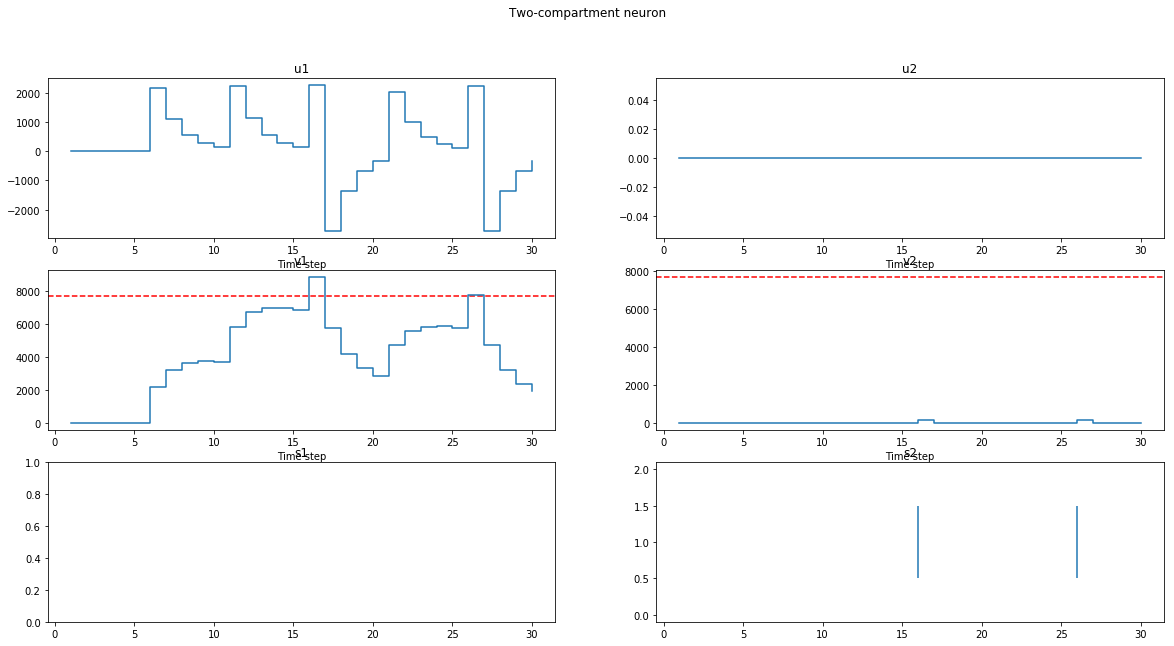

In [8]:
plt.figure(figsize=(20, 10))
plt.suptitle('Two-compartment neuron')
plotCxState(cInProbes0[0], cInProbes0[1], cInProbes0[2], 1, 2, vth)
plotCxState(cSomaProbes0[0], cSomaProbes0[1], cSomaProbes0[2], 2, 2, vth)

### Three-compartment neuron
The membrane potential v1 immediately decreases after the third input spike, same as shown in j_soft_reset_core.

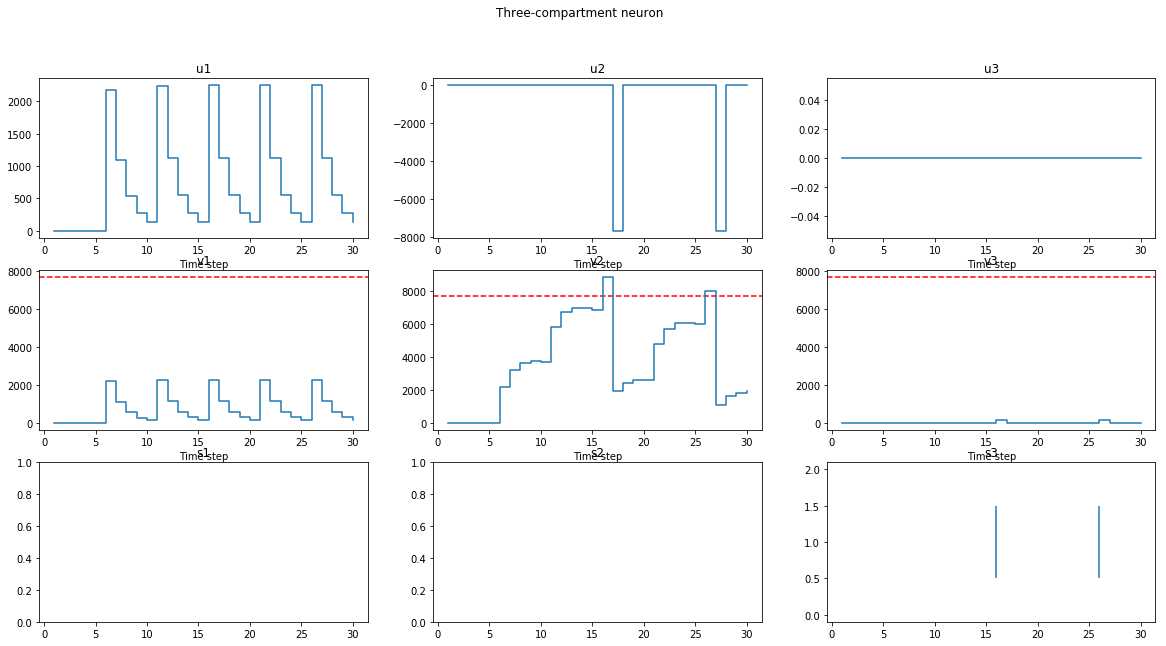

In [9]:
plt.figure(figsize=(20, 10))
plt.suptitle('Three-compartment neuron')
plotCxState(cInProbes1[0], cInProbes1[1], cInProbes1[2], 1, 3, vth)
plotCxState(cMiddleProbes1[0], cMiddleProbes1[1], cMiddleProbes1[2], 2, 3, vth)
plotCxState(cSomaProbes1[0], cSomaProbes1[1], cSomaProbes1[2], 3, 3, vth)

plt.show()

.. code-links:: python clear